# Practical Class 4 - Exercises on DAC/ADC modelling and DNL/INL error modelling

In [1]:
import numpy as np
from numpy.random import uniform, normal # import uniform and normal probability distributions to represent noise
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# define the function to convert a binary vector to decimal
def bin2dec(x, width):
    """Convert a numpy array from binary to decimal.
    IF the input is an array of binary arrays, 
    the returned output is an array of the corresponding 
    decimals in their corresponding indexes.
    Parameters:
        x: numpy array
        b: base of the number system
    """
    x = np.array(x)
    if x.size == width:
        assert len(x) == width, "The length of the vector must be equal to the number of bits"
        return reduce(lambda x,b: 2*x + b, x)
    assert len(x[0]) == width, "The length of the vector must be equal to the number of bits"
    return np.array(np.array([reduce(lambda xval,b: 2*xval + b, xval) for xval in x]))
def dec2bin(x, width):
    """Convert a numpy array from decimal to binary
    If the input is an array of decimals, the returned 
    binary arrays are the codes corresponding to 
    each decimal in its corresponding index.
    Parameters:
        x: numpy array
        b: base of the number system
    """
    x = np.array(x)
    if x.size == 1:
        return np.array([int(c) for c in np.binary_repr(x, width=width)])
    return np.array([np.array([int(c) for c in np.binary_repr(subx, width=width)]) for subx in x])

def ideal_dac(vref:float, n_bits:int):
    """Define the transfer function of an ideal 
    DAC biased by vref and presenting an n_bits resolution.
    Parameters:
        vref (float): The biasing voltage of the electronic system.
        n_bits (int): The resolution of the DAC.
    Returns:
        function(Din): the lambda function defining the transfer function of the DAC
    """
    vlsb = vref/(2**n_bits) # compute the fundamental step voltage between quantized levels
    return lambda x: bin2dec(x, n_bits)*vlsb # return the converter funtion

def ideal_adc(vref:float, nbits:int, roundf):
    """Define the transfer function of an ideal 
    ADC biased by vref and presenting an n_bits resolution.
    Parameters:
        vref (float): The biasing voltage of the electronic system.
        n_bits (int): The resolution of the DAC.
        roundf (function): The rounding function to be used.
    Returns:
        function(Vin): the lambda function defining the transfer function of the ADC
    """
    assert roundf in [np.round, np.ceil, np.floor], "The round function must be numpy.floor, numpy.ceil or numpy.round"
    vlsb = vref/(2**nbits)
    return lambda x: dec2bin(roundf(x/vlsb).astype(int), nbits)

In [3]:
# define the number of simulation points
Np = 1000
# define the frequency of the sampling clock
Fclk = 100e3 # Hz
# define the time base
dt = 1/Fclk
tD = np.arange(0, Np*dt, dt)

## Problem 9

In [4]:
# define the input signal
A1 = 100e-3
f1 = 1e3
ph1 = 0
s1 = A1*np.sin(2*np.pi*f1*tD + ph1)

# define the ideal ADC parameters
vref = 5 # V
nbit = 12
vlsb = vref/(2**nbit)

# define the quantization noise
p_nq = (vlsb**2)/ 12 # variance of the uniform quantization noise == power of the quantization noise
v_nq = np.sqrt(p_nq) # standard deviation of the uniform quantization noise

# define the power of the signal 
pin = (A1**2)/2 # power of the input sine wave

# compute the snr for A1 = 100 mV
snr = 10*np.log10(pin/p_nq)
print("SNR for $A_{in} = 100 mV$ : " + "{:.2f} dB".format(snr))

SNR for $A_{in} = 100 mV$ : 46.05 dB


In [5]:
# compute the maximum snr (A1  = Vref/2 V = 2.5 V)
A2 = vref/2
snr_max = 10*np.log10((A2**2 / 2)/p_nq)
snr_max_compare = 6.02*nbit + 1.76
print("Maximum SNR for $A_{in} = V_{ref}/2$ : " + "{:.2f} dB".format(snr_max))
print("Maximum SNR obtained using ideal SNR expression : " + "{:.2f} dB".format(snr_max_compare))
assert np.isclose(snr_max, snr_max_compare, 1e-2), "The maximum SNR is not correct"

Maximum SNR for $A_{in} = V_{ref}/2$ : 74.01 dB
Maximum SNR obtained using ideal SNR expression : 74.00 dB


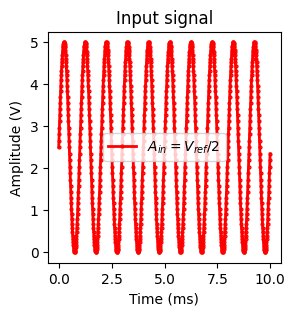

In [6]:
# create the input signal with maximum amplitude
%matplotlib inline
s2 = A2*np.sin(2*np.pi*f1*tD + ph1) + vref/2
# observe the input signal
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
scale_time = 1e-3
ax.plot(tD/scale_time, s2, label="$A_{in} = V_{ref}/2$", color="r", linewidth=2, marker="o", markersize=2, mfc="None")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Amplitude (V)")
ax.set_title("Input signal")
ax.legend()
plt.show()

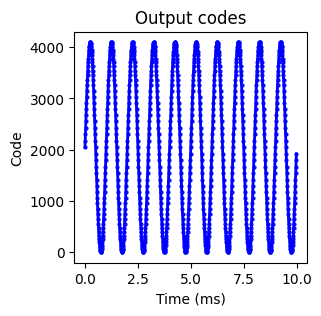

In [7]:
# compute the output codes of the ideal ADC
dout = np.round(s2/vlsb).astype(int)
# plot the output codes
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(tD/scale_time, dout, color="b", linewidth=2, marker="o", markersize=2, mfc="None")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Code")
ax.set_title("Output codes")
plt.show()

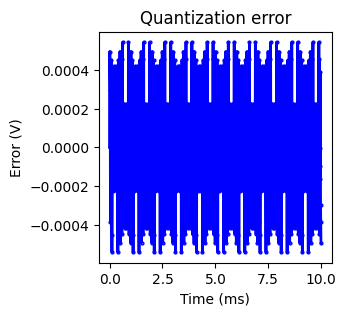

In [8]:
# compute the quantization error
error = dout*vlsb - s2
# plot the quantization error
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(tD/scale_time, error, color="b", linewidth=2, marker="o", markersize=2, mfc="None")
ax.set_xlabel("Time (ms)")
ax.set_ylabel("Error (V)")
ax.set_title("Quantization error")
plt.show()

In [9]:
# compute the standard deviation of the quantization error and compare it with the theoretical value
std_dev_error = np.std(error)
print("Standard deviation of the quantization error : " + "{:.2f} mV".format(std_dev_error*1e3))
print("Standard deviation of the quantization error (theoretical) : " + "{:.2f} mV".format(v_nq*1e3))
assert np.isclose(std_dev_error, v_nq, 1e-0), "The standard deviation of the quantization error is not correct"

Standard deviation of the quantization error : 0.29 mV
Standard deviation of the quantization error (theoretical) : 0.35 mV


## Problem 10

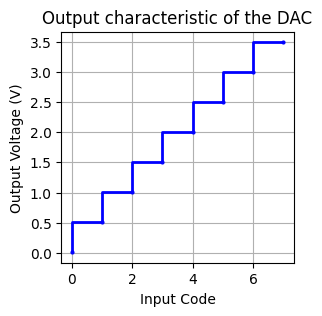

In [10]:
# consider a dac with 3 bits resolution
vref = 4 # V
nbit = 3 # bits
vlsb = vref/(2**nbit)
din = np.arange(0, 2**nbit, 1).astype(int)

# consider the output characterisitic of the DAC
vout_nonideal = np.array([0.011, 0.507, 1.002, 1.501, 1.996, 2.495, 2.996, 3.491])
vout_ideal = din*vlsb
# plot the output characteristic of the DAC
fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.step(din, vout_nonideal, color="b", linewidth=2, marker="o", markersize=2, mfc="None")
ax.set_xlabel("Input Code")
ax.set_ylabel("Output Voltage (V)")
ax.set_title("Output characteristic of the DAC")
ax.grid()
plt.show()

In [11]:
# compute the offset and gain error of the DAC
offset = (vout_nonideal[0] + vout_ideal[0])/vlsb # lsb
print("Computed offset error : " + "{:.2f} LSB".format(offset))

# compute the end of scale error of the DAC
end_of_scale = (vout_nonideal[-1] - vout_ideal[-1])/vlsb # lsb
print("Computed end of scale error : " + "{:.2f} LSB".format(end_of_scale))

"""
Note that the expressions of the DNL and INL aleady 
automatically removes the offset and gain error of the dac, 
through the computation of the real, measured vlsb.
"""

Computed offset error : 0.02 LSB
Computed end of scale error : -0.02 LSB


'\nNote that the expressions of the DNL and INL aleady \nautomatically removes the offset and gain error of the dac, \nthrough the computation of the real, measured vlsb.\n'

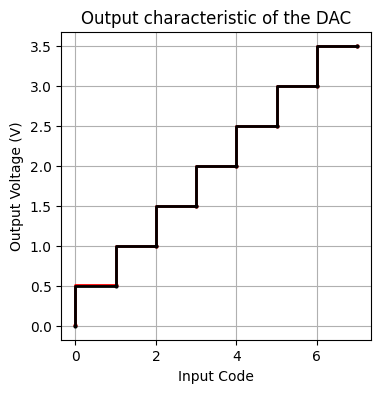

In [12]:
# plot the output characteristic of the DAC against the previous one and the ideal one
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.step(din, vout_nonideal, color="r", linewidth=2, marker="o", markersize=2, mfc="None", label="Non-ideal")
ax.step(din, vout_ideal, color="k", linewidth=2, marker="o", markersize=2, mfc="None", label="Ideal")
ax.set_xlabel("Input Code")
ax.set_ylabel("Output Voltage (V)")
ax.set_title("Output characteristic of the DAC")
ax.grid(True)
plt.show()

Measured LSB : 497.14 mV
Theoretical LSB : 500.00 mV


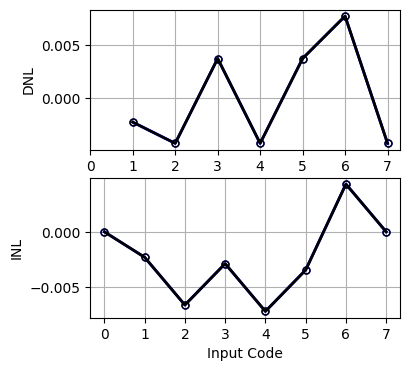

In [13]:
# compute the non-linear errors of the DAC 
# compute the measured LSB voltage
vlsb_measured = (vout_nonideal[-1] - vout_nonideal[0])/((2**nbit) - 1)
print("Measured LSB : " + "{:.2f} mV".format(vlsb_measured*1e3))
print("Theoretical LSB : " + "{:.2f} mV".format(vlsb*1e3))

# compute the DNL 
dnl = np.diff(vout_nonideal)/vlsb_measured - 1
dnl_classic = (vout_nonideal[1:] - vout_nonideal[:-1])/vlsb_measured - 1
assert np.allclose(dnl, dnl_classic), "The DNL is not correct"
# compute the INL
inl = (vout_nonideal - vlsb_measured*din - vout_nonideal[0])/vlsb_measured
# compute the inl using the cumsum
inl_cumsum = np.array([0] + np.cumsum(dnl).tolist())
dnl_diff = np.diff(inl)
# plot the DNL and INL
fig, ax = plt.subplots(2, 1, figsize=(4, 4))
ax[0].plot(din[1:], dnl, color="b", linewidth=2, marker="o", markersize=5, mfc="None")
ax[0].plot(din[1:], dnl_diff, color="k", linewidth=2, marker="o", markersize=5, mfc="None")
ax[0].set_ylabel("DNL")
ax[0].set_xticks(din)
ax[1].plot(din, inl, color="b", linewidth=2, marker="o", markersize=5, mfc="None")
ax[1].plot(din, inl_cumsum, color="k", linewidth=2, marker="o", markersize=5, mfc="None")
ax[1].set_xlabel("Input Code")
ax[1].set_xticks(din)
ax[1].set_ylabel("INL")
ax[0].grid(True)
ax[1].grid(True)
plt.show()

<p align="justify">
<b>Note :</b> that first and last point of the INL is 0.0 LSB, and this must always be true
once the expression we use to compute the INL automatically removes the offset and gain error of the DAC
(by subtracting vlsb_measured * din[0] and dividing by vlsb_measured, respectively).
</p>

In [14]:
# compute the effective number of bits of the DAC using the INL (once the lost bits can be compute by the 
# difference between the minimum and maximum value of the INL)
dac_linearity = nbit - np.log2(np.max(inl) - np.min(inl))
print("Effective number of bits (ENOB) : " + "{:.2f}".format(dac_linearity))

"""
The linearity of the DAC doesn't measure the resolution of the DAC, 
it actually measures how aligned each code transition is with the code transitions
of an ideal DAC with 9,44 bits of resolution. If the max(INL) - min(INL) covnerges towards 0 LSB,
linearity of the DAC converges towards infinity, being able to preserve a resolution of infinite number of bits 
when performing digital-to-analog conversion.
"""

Effective number of bits (ENOB) : 9.44


"\nThe linearity of the DAC doesn't measure the resolution of the DAC, \nit actually measures how aligned each code transition is with the code transitions\nof an ideal DAC with 9,44 bits of resolution. If the max(INL) - min(INL) covnerges towards 0 LSB,\nlinearity of the DAC converges towards infinity, being able to preserve a resolution of infinite number of bits \nwhen performing digital-to-analog conversion.\n"

## Problem 12

vn level =  0.0003662109375 V


/var/folders/vv/xctyh4bd2td6k2w_gvh_t2vr0000gn/T/ipykernel_86677/3114359422.py:29: RuntimeWarning: divide by zero encountered in log10
  dout_db = 10*np.log10(dout_p)


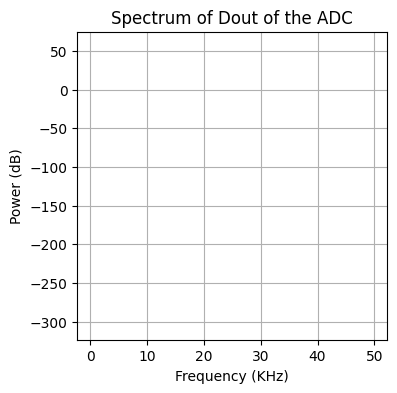

In [15]:
# define the adc
nbit = 12
vref = 3 
vlsb = vref/(2**nbit)

# define the input signal
A3 = 1 # V
f3 = 1e3 # Hz
f3 = np.round(f3/Fclk* Np)*Fclk/Np # Hz
ph1 = 0 # rad
vn = vlsb/2 # V
print("vn level = ", vn, "V")
s3 = A3*np.sin(2*np.pi*f3*tD + ph1) + normal(0, vn**2, Np)# V

# compute the quantization error
p_nq = vlsb**2 / 12 # V**2
vnq = np.sqrt(p_nq) # V
# define the input signal with quantization error
vnq_t = uniform(-vnq, vnq, len(tD)) # V

# define the dout 
dout = np.round(s3 / vlsb).astype(int)

ffactor = 1e3
fD = np.fft.fftshift(np.fft.fftfreq(Np, dt))
# compute the fft of the dout signal 
dout_f = np.abs(np.fft.fftshift(np.fft.fft(dout) / Np))
dout_p = dout_f**2
dout_db = 10*np.log10(dout_p)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(fD[fD>=0]/ffactor, dout_db[fD>=0], label="Input signal")
ax.set_xlabel("Frequency (KHz)")
ax.set_ylabel("Power (dB)")
ax.set_title("Spectrum of Dout of the ADC")
ax.grid(True)
plt.show()


In [16]:
# compute the snr of the ADC using the spectrum of dout
fbin = np.where(fD == f3) # get the bin of the signal
assert np.all(fbin == np.nan) == False, "The signal is not present in the spectrum of the output signal"
dout_p_fin = dout_p[fD == f3] # get the power of the input signal
dout_p_fin = dout_p_fin[~np.isnan(dout_p_fin)][0] # get the power of the input signal
print ("Power of the input signal : ", dout_p_fin, "V**2")
ideal_spectrum = np.zeros(len(dout_p)) # create an ideal spectrum
ideal_spectrum[fD == f3] = dout_p_fin # set the power of the input signal in the ideal spectrum
q_noise_p = np.var(dout_p - ideal_spectrum) # get the power of the quantization noise
print("Power of the quantization noise : ", q_noise_p, "V**2")
snr = 10*np.log10(dout_p_fin / q_noise_p) # compute the snr
print("SNR of the ADC : ", snr, "dB")

Power of the input signal :  466061.6710636067 V**2
Power of the quantization noise :  216996267.64349565 V**2
SNR of the ADC :  -26.68008876006169 dB


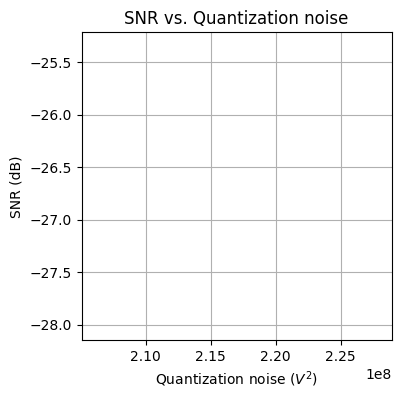

In [17]:
# plot the snr of the adc against the noise of the input signal
vni = 1e-10
noise_step = (vlsb/2 - vni)/Np
noise = np.arange(vni, vlsb/2, noise_step)
qnoise = []
snrs = []
for vn in noise:
    s3 = A3*np.sin(2*np.pi*f3*tD + ph1) + normal(0, vn**2, Np)# V
    dout = np.round(s3 / vlsb).astype(int)
    # compute the fft of the dout signal
    dout_f = np.abs(np.fft.fftshift(np.fft.fft(dout) / Np))
    dout_p = dout_f**2
    dout_p_fin = dout_p[fD == f3] # get the power of the input signal
    dout_p_fin = dout_p_fin[~np.isnan(dout_p_fin)][0] # get the power of the input signal
    ideal_spectrum = np.zeros(len(dout_p)) # create an ideal spectrum
    ideal_spectrum[fD == f3] = dout_p_fin # set the power of the input signal in the ideal spectrum
    q_noise_p = np.var(dout_p - ideal_spectrum) # get the power of the quantization noise
    snr = 10*np.log10(dout_p_fin / q_noise_p) # compute the snr
    qnoise.append(q_noise_p)
    snrs.append(snr)
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax.plot(np.array(qnoise), np.array(snrs), label="Input signal", color="b", linewidth=2, marker="None", markersize=5, mfc="None")
ax.set_xlabel("Quantization noise ($V^2$)")
ax.set_ylabel("SNR (dB)")
ax.set_title("SNR vs. Quantization noise")
ax.grid(True)
plt.show()
